In [22]:
import pandas as pd
import numpy as np
import logging
import re
import matplotlib.pyplot as plt

logger = logging.getLogger("lida")

In [12]:
def file_to_df(file_location: str):
    """ Get summary of data from file location """
    file_name = file_location.split("/")[-1]
    df = None
    if "csv" in file_name:
        df = pd.read_csv(file_location)
    elif "xlsx" in file_name:
        df = pd.read_excel(file_location)
    elif "json" in file_name:
        df = pd.read_json(file_location, orient="records")
    elif "parquet" in file_name:
        df = pd.read_parquet(file_location)
    elif "feather" in file_name:
        df = pd.read_feather(file_location)

    return df


def clean_column_name(col_name: str) -> str:
    """
    Clean a single column name by replacing special characters and spaces with underscores.

    :param col_name: The name of the column to be cleaned.
    :return: A sanitized string valid as a column name.
    """
    return re.sub(r'[^0-9a-zA-Z_]', '_', col_name)


def clean_column_names(df: pd.DataFrame) -> pd.DataFrame:
    """
    Clean all column names in the given DataFrame.

    :param df: The DataFrame with possibly dirty column names.
    :return: A copy of the DataFrame with clean column names.
    """
    cleaned_df = df.copy()
    cleaned_df.columns = [clean_column_name(col) for col in cleaned_df.columns]
    return cleaned_df


def read_dataframe(file_location: str, encoding: str = 'utf-8') -> pd.DataFrame:
    """
    Read a dataframe from a given file location and clean its column names.
    It also samples down to 4500 rows if the data exceeds that limit.

    :param file_location: The path to the file containing the data.
    :param encoding: Encoding to use for the file reading.
    :return: A cleaned DataFrame.
    """
    file_extension = file_location.split('.')[-1]

    read_funcs = {
        'json': lambda: pd.read_json(file_location, orient='records', encoding=encoding),
        'csv': lambda: pd.read_csv(file_location, encoding=encoding),
        'xls': lambda: pd.read_excel(file_location, encoding=encoding),
        'xlsx': lambda: pd.read_excel(file_location, encoding=encoding),
        'parquet': pd.read_parquet,
        'feather': pd.read_feather,
        'tsv': lambda: pd.read_csv(file_location, sep="\t", encoding=encoding)
    }

    if file_extension not in read_funcs:
        raise ValueError('Unsupported file type')

    try:
        df = read_funcs[file_extension]()
    except Exception as e:
        logger.error(f"Failed to read file: {file_location}. Error: {e}")
        raise

    # Clean column names
    cleaned_df = clean_column_names(df)

    # Sample down to 4500 rows if necessary
    # if len(cleaned_df) > 4500:
    #     logger.info(
    #         "Dataframe has more than 4500 rows. We will sample 4500 rows.")
    #     cleaned_df = cleaned_df.sample(4500)

    if cleaned_df.columns.tolist() != df.columns.tolist():
        write_funcs = {
            'csv': lambda: cleaned_df.to_csv(file_location, index=False, encoding=encoding),
            'xls': lambda: cleaned_df.to_excel(file_location, index=False),
            'xlsx': lambda: cleaned_df.to_excel(file_location, index=False),
            'parquet': lambda: cleaned_df.to_parquet(file_location, index=False),
            'feather': lambda: cleaned_df.to_feather(file_location, index=False),
            'json': lambda: cleaned_df.to_json(file_location, orient='records', index=False, default_handler=str),
            'tsv': lambda: cleaned_df.to_csv(file_location, index=False, sep='\t', encoding=encoding)
        }

        if file_extension not in write_funcs:
            raise ValueError('Unsupported file type')

        try:
            write_funcs[file_extension]()
        except Exception as e:
            logger.error(f"Failed to write file: {file_location}. Error: {e}")
            raise

    return cleaned_df

In [13]:
file_path = "C:/Long/Coding/Kaggle/Titanic/titanic/train.csv"

df = read_dataframe(file_path)

columns_names = df.columns.tolist()
columns_names

['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked']

In [19]:
def get_column_stats(df, column_name):
  """
  This function calculates various statistics for a given column in a DataFrame.

  Args:
      df (pandas.DataFrame): The DataFrame containing the column.
      column_name (str): The name of the column to analyze.

  Returns:
      dict: A dictionary containing the following keys:
          valid (int): Number of valid (non-null) values.
          mismatched (int): Number of values that don't match a specific criteria (optional).
          missing (int): Number of missing values (NaN).
          mean (float): Mean of the valid values.
          std (float): Standard deviation of the valid values.
  """
  # Count valid, missing, and total values
  valid_count = df[column_name].notnull().sum()
  missing_count = df[column_name].isnull().sum()
  total_count = len(df)

  # Calculate mean and standard deviation (excluding missing values)
  mean = round(df[column_name].dropna().mean(), 1) if valid_count > 0 else None
  std = round(df[column_name].dropna().std(), 1) if valid_count > 0 else None

  # Add mismatched count if specific criteria is provided (optional)
  mismatched_count = 0  # Initialize to 0

  # Replace with your logic to identify mismatched values
  # For example:
  # if pd.api.types.is_numeric_dtype(df[column_name]):
  #     mismatched_count = (df[column_name] < specific_value).sum()

  # Create the dictionary with statistics
  stats = {
      "valid": valid_count,
      "missing": missing_count,
      "mean": mean,
      "std": std,
  }

  # Add mismatched count if calculated
  if mismatched_count > 0:
    stats["mismatched"] = mismatched_count

  return stats


In [20]:
get_column_stats(df, "Age")

{'valid': 714, 'missing': 177, 'mean': 29.7, 'std': 14.5}

(array([ 54.,  46., 177., 169., 118.,  70.,  45.,  24.,   9.,   2.]),
 array([ 0.42 ,  8.378, 16.336, 24.294, 32.252, 40.21 , 48.168, 56.126,
        64.084, 72.042, 80.   ]),
 <BarContainer object of 10 artists>)

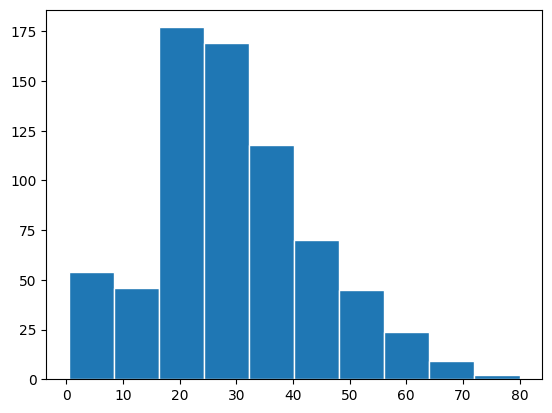

In [25]:
plt.hist(df["Age"], edgecolor="white")

In [ ]:
!pip install plotly